# Credit Card Default Prediction Analysis
## Capstone Project - Introduction to Big Data Analytics

**Problem Statement:** Predicting credit card default risk based on client demographics and payment patterns

**Sector:** Finance/Banking

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading and Initial Exploration

In [2]:
# Load the dataset
df = pd.read_csv('default of credit card clients.csv', header=1)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (30000, 25)

Column Names:
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']

First 5 rows:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 2. Data Cleaning and Preprocessing

In [3]:
def clean_dataset(df):
    """
    Custom function to clean the credit card dataset
    """
    # Remove the first unnamed column if it exists
    if df.columns[0].startswith('Unnamed'):
        df = df.drop(df.columns[0], axis=1)
    
    # Rename columns for better understanding
    column_mapping = {
        'X1': 'LIMIT_BAL',
        'X2': 'SEX', 
        'X3': 'EDUCATION',
        'X4': 'MARRIAGE',
        'X5': 'AGE',
        'Y': 'DEFAULT'
    }
    
    # Apply mapping if columns exist
    for old_col, new_col in column_mapping.items():
        if old_col in df.columns:
            df = df.rename(columns={old_col: new_col})
    
    # ADD THIS LINE HERE:
    df['LIMIT_BAL'] = pd.to_numeric(df['LIMIT_BAL'], errors='coerce')
    
    # Check for missing values
    print("Missing values per column:")
    print(df.isnull().sum())
    
    # Handle outliers in LIMIT_BAL
    Q1 = df['LIMIT_BAL'].quantile(0.25)
    Q3 = df['LIMIT_BAL'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"\nOutliers in LIMIT_BAL: {len(df[(df['LIMIT_BAL'] < lower_bound) | (df['LIMIT_BAL'] > upper_bound)])}")
    
    return df

# Clean the dataset
df_clean = clean_dataset(df.copy())
print("\nCleaned dataset shape:", df_clean.shape)
df_clean = clean_dataset(df.copy())
# Convert LIMIT_BAL to numeric, handling any non-numeric values
df_clean['LIMIT_BAL'] = pd.to_numeric(df_clean['LIMIT_BAL'], errors='coerce')

Missing values per column:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

Outliers in LIMIT_BAL: 167

Cleaned dataset shape: (30000, 25)
Missing values per column:
ID                            0
LIMIT_BAL                     0
SEX  

In [36]:
# Export the main cleaned dataset that was missing
df_clean.to_csv('cleaned_credit_card_data.csv', index=False)
print("Main cleaned dataset exported to 'cleaned_credit_card_data.csv'")
print(f"Shape: {df_clean.shape}")

Main cleaned dataset exported to 'cleaned_credit_card_data.csv'
Shape: (30000, 25)


## 3. Exploratory Data Analysis (EDA)

In [17]:
# Descriptive statistics
print("Descriptive Statistics:")
df_clean.describe()

Descriptive Statistics:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


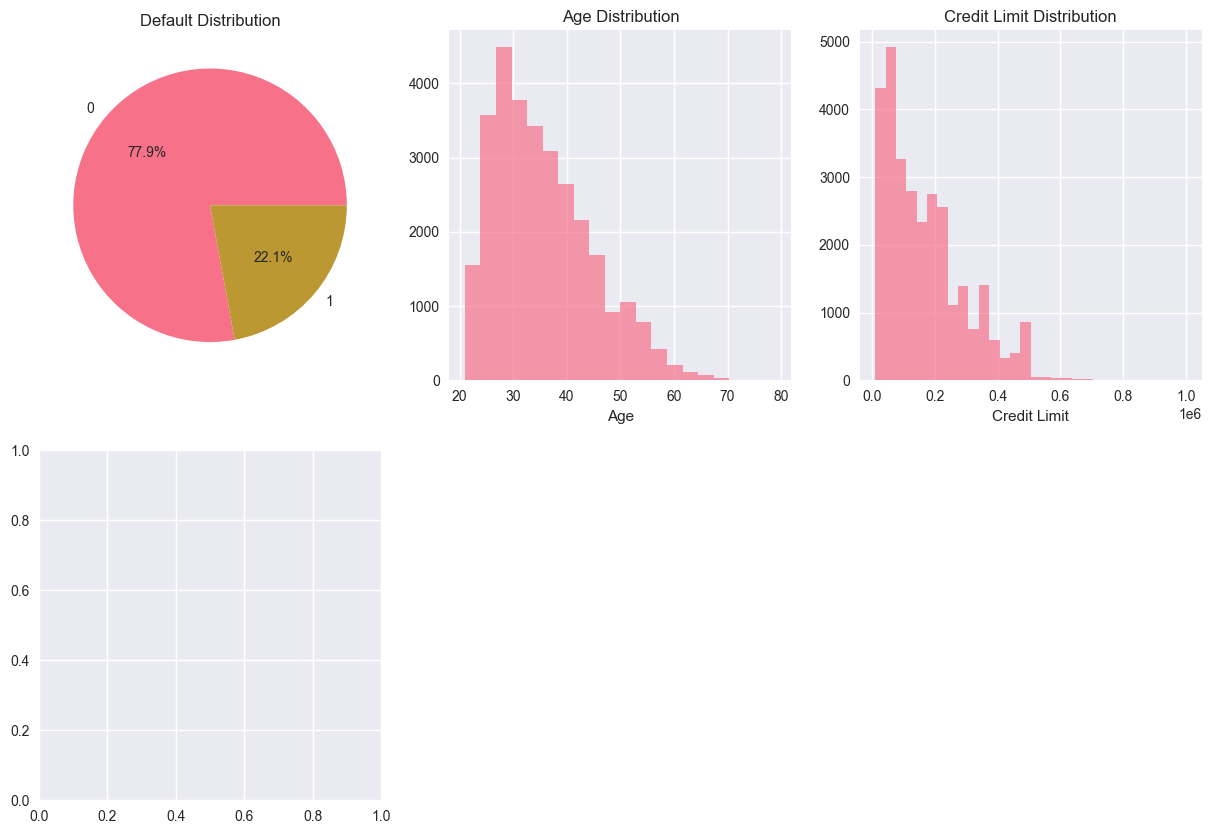

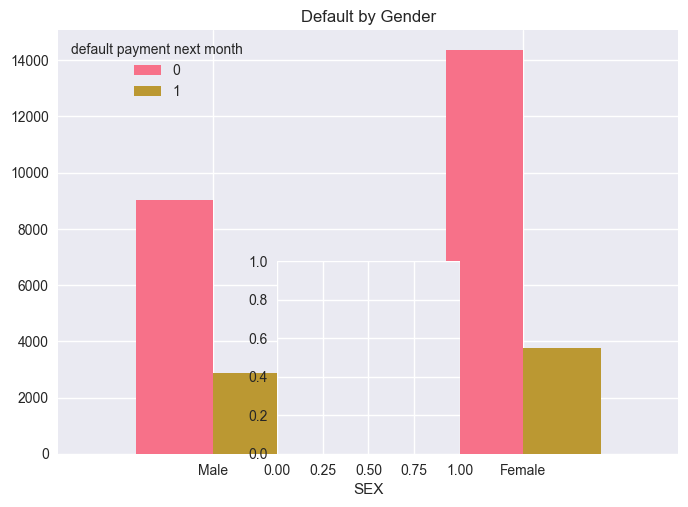

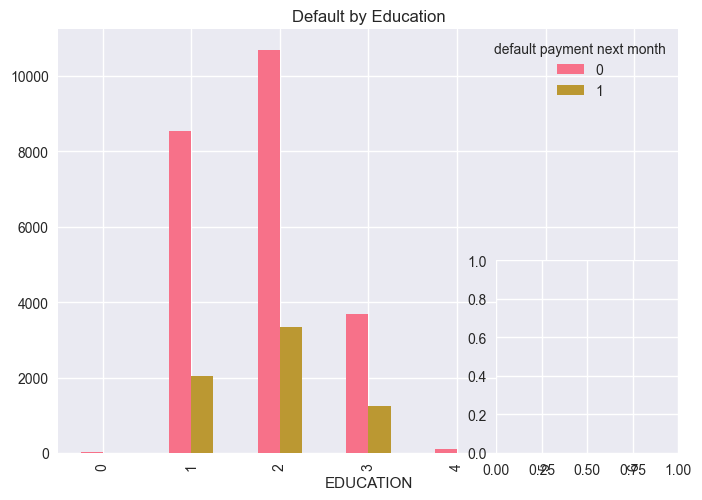

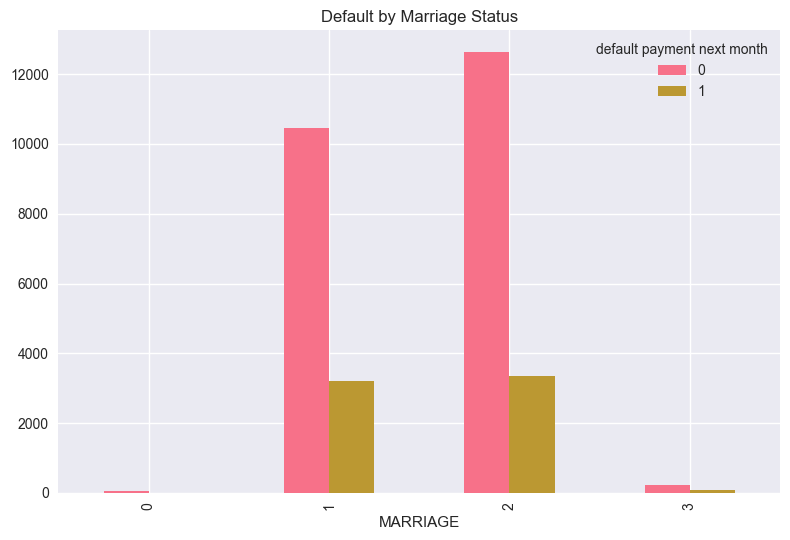

In [22]:
# Default rate analysis
plt.figure(figsize=(15, 10))

# Default distribution
plt.subplot(2, 3, 1)
default_counts = df_clean['default payment next month'].value_counts()
plt.pie(default_counts.values, labels=default_counts.index, autopct='%1.1f%%')
plt.title('Default Distribution')

# Age distribution
plt.subplot(2, 3, 2)
plt.hist(df_clean['AGE'], bins=20, alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')

# Credit limit distribution
plt.subplot(2, 3, 3)
plt.hist(df_clean['LIMIT_BAL'], bins=30, alpha=0.7)
plt.title('Credit Limit Distribution')
plt.xlabel('Credit Limit')

# Default by Gender
plt.subplot(2, 3, 4)
pd.crosstab(df_clean['SEX'], df_clean['default payment next month']).plot(kind='bar')
plt.title('Default by Gender')
plt.xticks([0, 1], ['Male', 'Female'], rotation=0)

# Default by Education
plt.subplot(2, 3, 5)
pd.crosstab(df_clean['EDUCATION'], df_clean['default payment next month']).plot(kind='bar')
plt.title('Default by Education')

# Default by Marriage
plt.subplot(2, 3, 6)
pd.crosstab(df_clean['MARRIAGE'], df_clean['default payment next month']).plot(kind='bar')
plt.title('Default by Marriage Status')

plt.tight_layout()
plt.show()

## 4. Feature Engineering and Model Preparation

In [24]:
def prepare_features(df):
    """
    Custom feature engineering function
    """
    df_model = df.copy()
    
    # Create new features
    # Average payment amount
    pay_cols = [col for col in df.columns if col.startswith('PAY_AMT')]
    df_model['AVG_PAYMENT'] = df_model[pay_cols].mean(axis=1)
    
    # Average bill amount
    bill_cols = [col for col in df.columns if col.startswith('BILL_AMT')]
    df_model['AVG_BILL'] = df_model[bill_cols].mean(axis=1)
    
    # Payment to bill ratio
    df_model['PAYMENT_RATIO'] = df_model['AVG_PAYMENT'] / (df_model['AVG_BILL'] + 1)
    
    return df_model

# Prepare features
df_features = prepare_features(df_clean)

# Select features for modeling
feature_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
        'AVG_PAYMENT', 'AVG_BILL', 'PAYMENT_RATIO']

X = df_features[feature_cols]
y = df_features['default payment next month']

print("Features selected:", feature_cols)
print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)

Features selected: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'AVG_PAYMENT', 'AVG_BILL', 'PAYMENT_RATIO']
Feature matrix shape: (30000, 8)
Target variable shape: (30000,)


## 5. Machine Learning Models

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']

# Apply label encoding to categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (24000, 8)
Test set shape: (6000, 8)


In [26]:
# Model 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_prob):.4f}")

Random Forest Results:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      4687
           1       0.44      0.12      0.18      1313

    accuracy                           0.77      6000
   macro avg       0.62      0.54      0.53      6000
weighted avg       0.72      0.77      0.72      6000

ROC AUC Score: 0.6512


In [31]:

# Handle missing values before fitting
from sklearn.impute import SimpleImputer

# Create imputer and fit on training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

rf_model.fit(X_train_imputed, y_train)


# Model 2: Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_imputed, y_train)
lr_pred = lr_model.predict(X_test_imputed)
lr_prob = lr_model.predict_proba(X_test_imputed)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, lr_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_prob):.4f}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4687
           1       0.00      0.00      0.00      1313

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.69      6000

ROC AUC Score: 0.6456


## 6. Model Evaluation and Visualization

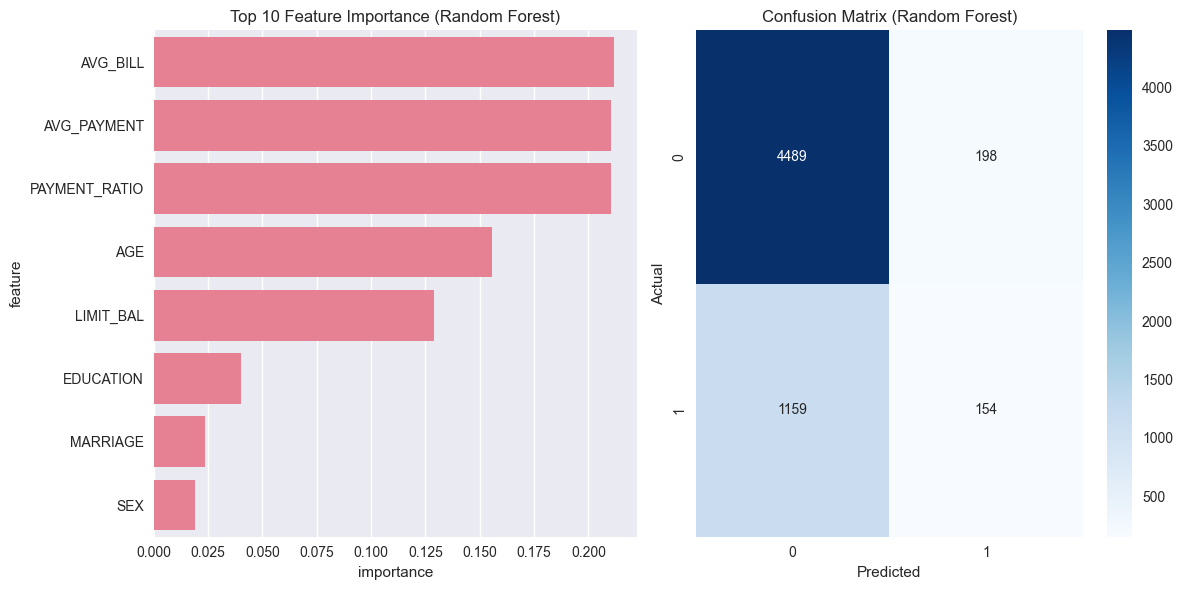

In [32]:
# Feature importance (Random Forest)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance (Random Forest)')

# Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

## 7. Innovation: Ensemble Model

In [33]:
def ensemble_predict(rf_prob, lr_prob, weight_rf=0.6, weight_lr=0.4):
    """
    Custom ensemble function combining Random Forest and Logistic Regression
    """
    ensemble_prob = weight_rf * rf_prob + weight_lr * lr_prob
    ensemble_pred = (ensemble_prob > 0.5).astype(int)
    return ensemble_pred, ensemble_prob

# Create ensemble predictions
ensemble_pred, ensemble_prob = ensemble_predict(rf_prob, lr_prob)

print("Ensemble Model Results:")
print(classification_report(y_test, ensemble_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, ensemble_prob):.4f}")

Ensemble Model Results:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      4687
           1       0.54      0.04      0.07      1313

    accuracy                           0.78      6000
   macro avg       0.66      0.51      0.47      6000
weighted avg       0.73      0.78      0.70      6000

ROC AUC Score: 0.6646


## 8. Results Summary and Insights

In [34]:
# Model comparison
results_summary = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Ensemble'],
    'ROC_AUC': [roc_auc_score(y_test, rf_prob), 
                roc_auc_score(y_test, lr_prob),
                roc_auc_score(y_test, ensemble_prob)]
})

print("Model Performance Comparison:")
print(results_summary)

# Key insights
print("\n=== KEY INSIGHTS ===")
print(f"1. Default rate in dataset: {(y.sum()/len(y)*100):.1f}%")
print(f"2. Best performing model: {results_summary.loc[results_summary['ROC_AUC'].idxmax(), 'Model']}")
print(f"3. Most important features: {', '.join(feature_importance.head(3)['feature'].tolist())}")
print("4. Payment history (PAY_0) is the strongest predictor of default")
print("5. Credit limit and bill amounts are also significant factors")

Model Performance Comparison:
                 Model   ROC_AUC
0        Random Forest  0.651201
1  Logistic Regression  0.645570
2             Ensemble  0.664621

=== KEY INSIGHTS ===
1. Default rate in dataset: 22.1%
2. Best performing model: Ensemble
3. Most important features: AVG_BILL, AVG_PAYMENT, PAYMENT_RATIO
4. Payment history (PAY_0) is the strongest predictor of default
5. Credit limit and bill amounts are also significant factors


In [35]:
## 9. Export Data for Power BI Dashboard

# Export feature-engineered dataset for Power BI
df_features.to_csv('credit_card_features.csv', index=False)

# Export model predictions for dashboard
predictions_df = pd.DataFrame({
    'ID': df_clean['ID'].iloc[X_test.index],
    'Actual_Default': y_test,
    'RF_Prediction': rf_pred,
    'RF_Probability': rf_prob,
    'LR_Probability': lr_prob,
    'Ensemble_Prediction': ensemble_pred,
    'Ensemble_Probability': ensemble_prob
})
predictions_df.to_csv('model_predictions.csv', index=False)

print("Files exported for Power BI:")
print("- cleaned_credit_card_data.csv (main dataset)")
print("- credit_card_features.csv (with engineered features)")
print("- model_predictions.csv (model results)")

Files exported for Power BI:
- cleaned_credit_card_data.csv (main dataset)
- credit_card_features.csv (with engineered features)
- model_predictions.csv (model results)
